# Building A Linear Regression with PySpark and MLlib
reference: https://towardsdatascience.com/building-a-linear-regression-with-pyspark-and-mllib-d065c3ba246a

In [1]:
!pip install kaggle >/dev/null
!pip install mleap > /dev/null

You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Install MLeap:
spark-shell --packages ml.combust.mleap:mleap-spark_2.11:0.10.0

Install Avro Data Source for Apache Spark:
spark-shell --packages com.databricks:spark-avro_2.11:4.0.0

In [2]:
import io, os
import zipfile
import pandas as pd
import six
try:
  from pathlib import Path
except ImportError:
  from pathlib2 import Path  # python 2 backport

In [3]:
# Write kaggle.json to ~/.kaggle/
filename = "/root/.kaggle/kaggle.json"

Path(os.path.dirname(filename)).mkdir(exist_ok=True)
!sudo gsutil cp gs://ontario-2018-dataproc/notebooks/kaggle.json {filename}
os.chmod(filename, 600)

CommandException: No URLs matched: gs://ontario-2018-dataproc/notebooks/kaggle.json


## Boston Housing Dataset
reference: https://www.kaggle.com/c/boston-housing/data

In [4]:
dataset = 'boston-housing'

In [5]:
folder = '/home/datalab/datasets/'+dataset
Path(os.path.dirname(folder)).mkdir(exist_ok=True)
if not os.path.isdir(folder):
  os.mkdir(folder)
os.chdir(folder)
os.system('kaggle competitions download -c '+dataset)
for file in os.listdir(folder):
  filename, file_extension = os.path.splitext(file)
  if file_extension == '.zip':
    zip_ref = zipfile.ZipFile(file, 'r')
    zip_ref.extractall()
    zip_ref.close()

In [6]:
training_dataset=os.path.abspath('train.csv')
print(training_dataset)

/home/datalab/datasets/boston-housing/train.csv


In [7]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext
sc= SparkContext()
sqlContext = SQLContext(sc)

In [8]:
!hdfs dfs -mkdir -p /datasets
!hadoop fs -put {training_dataset} /datasets
!hadoop fs -ls /datasets

18/11/06 16:32:04 INFO gcs.GoogleHadoopFileSystemBase: GHFS version: hadoop2-1.9.8
18/11/06 16:32:07 INFO gcs.GoogleHadoopFileSystemBase: GHFS version: hadoop2-1.9.8
put: `/datasets/train.csv': File exists
18/11/06 16:32:09 INFO gcs.GoogleHadoopFileSystemBase: GHFS version: hadoop2-1.9.8
Found 1 items
-rw-r--r--   2 root hadoop      24128 2018-11-06 16:29 /datasets/train.csv


In [9]:
house_df = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('/datasets/train.csv')
house_df.take(1)

[Row(ID=1, crim=0.00632, zn=18.0, indus=2.31, chas=0, nox=0.538, rm=6.575, age=65.2, dis=4.09, rad=1, tax=296, ptratio=15.3, black=396.9, lstat=4.98, medv=24.0)]

In [10]:
house_df.cache()
house_df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- crim: double (nullable = true)
 |-- zn: double (nullable = true)
 |-- indus: double (nullable = true)
 |-- chas: integer (nullable = true)
 |-- nox: double (nullable = true)
 |-- rm: double (nullable = true)
 |-- age: double (nullable = true)
 |-- dis: double (nullable = true)
 |-- rad: integer (nullable = true)
 |-- tax: integer (nullable = true)
 |-- ptratio: double (nullable = true)
 |-- black: double (nullable = true)
 |-- lstat: double (nullable = true)
 |-- medv: double (nullable = true)



In [11]:
house_df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
ID,333,250.95195195195194,147.8594378018597,1,506
crim,333,3.3603414714714708,7.352271836781104,0.00632,73.5341
zn,333,10.68918918918919,22.674761796618217,0.0,100.0
indus,333,11.29348348348346,6.998123104477312,0.74,27.74
chas,333,0.06006006006006006,0.2379556428164483,0,1
nox,333,0.557144144144145,0.11495450830289312,0.385,0.871
rm,333,6.265618618618616,0.7039515757334471,3.561,8.725
age,333,68.22642642642641,28.13334360562338,6.0,100.0
dis,333,3.7099336336336335,1.9811230514407001,1.1296,10.7103


In [12]:
numeric_features = [t[0] for t in house_df.dtypes if t[1] == 'int' or t[1] == 'double']
sampled_data = house_df.select(numeric_features).sample(False, 0.8).toPandas()
axs = pd.plotting.scatter_matrix(sampled_data, figsize=(10, 10))
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [13]:
for i in house_df.columns:
    if not( isinstance(house_df.select(i).take(1)[0][0], six.string_types)):
        print( "Correlation to MV for ", i, house_df.stat.corr('medv',i))

('Correlation to MV for ', 'ID', -0.22169418651611697)
('Correlation to MV for ', 'crim', -0.4074543235732598)
('Correlation to MV for ', 'zn', 0.34484197569664277)
('Correlation to MV for ', 'indus', -0.47393197065920345)
('Correlation to MV for ', 'chas', 0.20438998859918733)
('Correlation to MV for ', 'nox', -0.4130541519920783)
('Correlation to MV for ', 'rm', 0.6895980892872156)
('Correlation to MV for ', 'age', -0.35888827406190227)
('Correlation to MV for ', 'dis', 0.24942226829396397)
('Correlation to MV for ', 'rad', -0.3522508242456341)
('Correlation to MV for ', 'tax', -0.44807769440070433)
('Correlation to MV for ', 'ptratio', -0.48137595552491735)
('Correlation to MV for ', 'black', 0.33665955532155767)
('Correlation to MV for ', 'lstat', -0.7386000348786346)
('Correlation to MV for ', 'medv', 1.0)


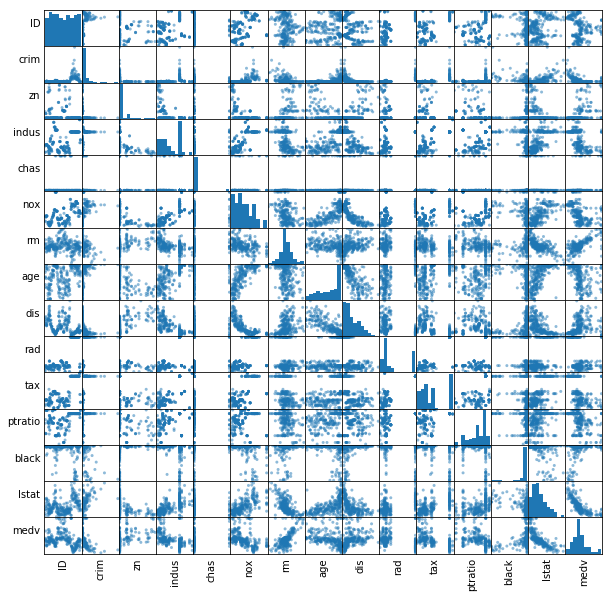

In [14]:
numeric_features = [t[0] for t in house_df.dtypes if t[1] == 'int' or t[1] == 'double']
sampled_data = house_df.select(numeric_features).sample(False, 0.8).toPandas()
axs = pd.plotting.scatter_matrix(sampled_data, figsize=(10, 10))
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [15]:
house_df.columns

['ID',
 'crim',
 'zn',
 'indus',
 'chas',
 'nox',
 'rm',
 'age',
 'dis',
 'rad',
 'tax',
 'ptratio',
 'black',
 'lstat',
 'medv']

In [16]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = ['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'black', 'lstat'], outputCol = 'features')
vhouse_df = vectorAssembler.transform(house_df)
vhouse_df = vhouse_df.select(['features', 'medv'])
vhouse_df.show(3)

+--------------------+----+
|            features|medv|
+--------------------+----+
|[0.00632,18.0,2.3...|24.0|
|[0.02731,0.0,7.07...|21.6|
|[0.03237,0.0,2.18...|33.4|
+--------------------+----+
only showing top 3 rows



In [17]:
splits = vhouse_df.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

In [18]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='medv', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [0.0,0.035465794320104785,0.0,3.199107352308378,-4.1514250230121705,3.252993210567255,-0.0070267191489583585,-1.0203258624033211,0.04492638286173233,0.0,-0.720004569750821,0.010806946734514732,-0.6589389876295543]
Intercept: 25.715921009


In [19]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 5.226261
r2: 0.698654


In [20]:
train_df.describe().show()

+-------+------------------+
|summary|              medv|
+-------+------------------+
|  count|               232|
|   mean|22.667672413793113|
| stddev| 9.541059036915264|
|    min|               5.0|
|    max|              50.0|
+-------+------------------+



In [21]:
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction","medv","features").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="medv",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+------------------+----+--------------------+
|        prediction|medv|            features|
+------------------+----+--------------------+
|27.234727647789942|22.0|[0.01096,55.0,2.2...|
|30.234362958472254|35.4|[0.01311,90.0,1.2...|
|17.504107169729604|18.9|[0.0136,75.0,4.0,...|
|31.181472506590005|29.1|[0.01439,60.0,2.9...|
| 26.58437037621097|23.1|[0.0187,85.0,4.15...|
+------------------+----+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 0.754679


In [22]:
test_result = lr_model.evaluate(test_df)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

Root Mean Squared Error (RMSE) on test data = 4.09458


In [23]:
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()

numIterations: 11
objectiveHistory: [0.5000000000000004, 0.4343440164034731, 0.2561356828724204, 0.23353695917150905, 0.20292880878316782, 0.19686251163126028, 0.19471518721748643, 0.19042335489566872, 0.18983059890091464, 0.18937190145341104, 0.18927796741276767]
+--------------------+
|           residuals|
+--------------------+
|   -6.91461160433364|
|  1.3755911396966525|
|   2.016936189675725|
| -0.3458788968426454|
| -3.3260831332739613|
|   7.518206106140596|
|  1.0688470110045714|
|  10.035322014692198|
| -0.5334384363920606|
|   -8.63759159332713|
| -2.9742495824232833|
|0.023897163856233306|
|   1.268326445642952|
|   4.330069883611742|
|  1.1443936000433155|
| -1.0192052450608884|
|  -5.062002974740249|
|   9.721962287976034|
|  -5.413553141132994|
|  -1.929258848890317|
+--------------------+
only showing top 20 rows



In [24]:
predictions = lr_model.transform(test_df)
predictions.select("prediction","medv","features").show()

+------------------+----+--------------------+
|        prediction|medv|            features|
+------------------+----+--------------------+
|27.234727647789942|22.0|[0.01096,55.0,2.2...|
|30.234362958472254|35.4|[0.01311,90.0,1.2...|
|17.504107169729604|18.9|[0.0136,75.0,4.0,...|
|31.181472506590005|29.1|[0.01439,60.0,2.9...|
| 26.58437037621097|23.1|[0.0187,85.0,4.15...|
|23.577934074362602|33.0|[0.01951,17.5,1.3...|
|19.838161248697507|20.1|[0.01965,80.0,1.7...|
|26.288058072137147|24.7|[0.02055,85.0,0.7...|
|28.305022401992172|23.9|[0.02543,55.0,3.7...|
| 28.31028655582834|25.0|[0.02875,28.0,15....|
|24.905656415672283|26.6|[0.02899,40.0,1.2...|
| 22.46974694569394|20.6|[0.03306,0.0,5.19...|
|32.199616605797324|28.5|[0.03502,80.0,4.9...|
|30.290948694950522|23.5|[0.03584,80.0,3.3...|
|30.577048997274115|27.9|[0.03615,80.0,4.9...|
| 23.60346971986634|20.6|[0.04527,0.0,11.9...|
|25.975776158588324|23.3|[0.0456,0.0,13.89...|
|31.453631744540147|30.3|[0.04666,80.0,1.5...|
|  23.8641441